In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal

import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import celluloid
import seaborn as sns


In [2]:
dir_path1 = "data/entklerg12/"
# Load Pickled Data
file_path1 = dir_path1 + "data_eval_dict.pickle"
with open(file_path1, 'rb') as f: 
    data_dict1 = pickle.load(f, encoding="bytes")
    print(data_dict1.keys())
obj1 = data_dict1['obj_loc']
# obj2 = data_dict1['obj_loc']
traj1 = data_dict1['path']
loss1 = data_dict1['losses']
buffer1 = data_dict1['buffer']
action1 = data_dict1['actions']
env_traj1 = data_dict1['env_path']
env_lim = data_dict1['tray_lim']
klerg_lim = data_dict1['klerg_lim']
print(obj1)

dict_keys(['path', 'actions', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'losses', 'tray_lim', 'klerg_lim'])
(-0.15, -0.1, -0.35)


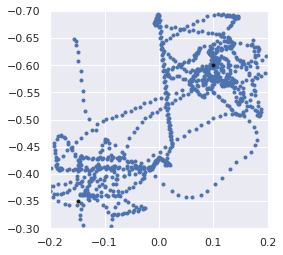

In [3]:
sns.set(style='darkgrid')
# Plot Traj
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')
plt.plot(obj1[0], obj1[2],'k.')
plt.plot(0.1, -0.6,'k.')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
plt.show()


[ 0.17251726  0.3        -0.64636831] (3, 75, 75) (-0.15, -0.1, -0.35)
tensor([[-0.7500, -0.7500]])
torch.Size([1, 2]) torch.Size([1, 5625])
torch.Size([1, 18]) torch.Size([1, 2])
torch.Size([1, 5626])
torch.Size([1, 18]) torch.Size([1, 2])


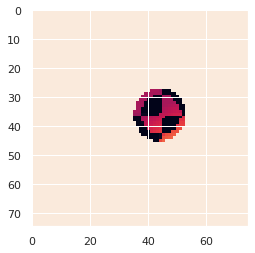

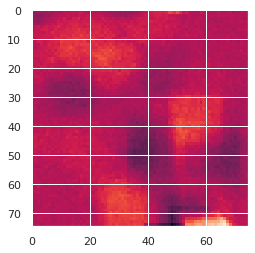

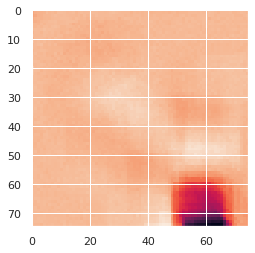

In [5]:
from franka.franka_utils import *

# Load Pytorch Models
model1 = torch.load("model_ent_check.pth")
model1.eval()

print(env_traj1[-1,:], buffer1[-1][1].shape, obj1)
yr = np.mean(buffer1[-1][1], axis=0).flatten()
xr = np.expand_dims(buffer1[-1][0], axis=0)
yr = np.expand_dims(yr, axis=0)

xr = torch.FloatTensor(xr)#.squeeze()
yr = torch.FloatTensor(yr)#.squeeze()
x_obj = ws_conversion([obj1[0],obj1[2]], env_lim, klerg_lim)

x_obj = torch.FloatTensor(np.expand_dims(x_obj,axis=0))
print(x_obj)
print(xr.shape, yr.shape)
with torch.no_grad():
    img_pred, img_logvar , z_mu, z_logvar, z_samples = model1(xr, yr)
    z_samples = model1.reparameterize(z_mu, z_logvar)

    print(z_samples.shape, xr.shape)
    y_pred = model1.img_decode(torch.cat([z_samples, xr], dim=1))
    print(y_pred.shape)
    img_pred = y_pred[:,1:].reshape((75,75))

    print(z_samples.shape, x_obj.shape)
    yo_pred = model1.img_decode(torch.cat([z_samples, x_obj], dim=1))
    imgo_pred =yo_pred[:,1:].reshape((75,75))

img_new = img_pred.detach().numpy().T
img_new = np.clip(img_new,0,1)

imgo_new = imgo_pred.detach().numpy().T
imgo_new = np.clip(imgo_new,0,1)

img_orig = yr.detach().numpy()[0].reshape((75,75))

plt.imshow(img_orig)
plt.show()

plt.imshow(img_new)
plt.show()

plt.imshow(imgo_new)
plt.show()


In [12]:
dir_path = "data/test_data2/"
# Load Pickled Data
file_path = dir_path + "data_eval_dict.pickle"
with open(file_path, 'rb') as f: 
    data_dict = pickle.load(f, encoding="bytes")
    print(data_dict.keys())
testobj1 = data_dict['obj_loc']
testobj2 = data_dict['obj2_loc']
testtraj = data_dict['path']
testbuffer = data_dict['buffer']
test_env_traj = data_dict['env_path']
test_env_lim = data_dict['tray_lim']
test_klerg_lim = data_dict['klerg_lim']
print(testobj1, testobj2)


ycheck1 = [None]*len(testbuffer)
# ycheck2 = [None]*len(testbuffer)

with torch.no_grad():
    xt = np.expand_dims(testbuffer[0][0], axis=0)
    yt = np.expand_dims(np.mean(testbuffer[0][1],axis=0).flatten(), axis=0)
    print(xt.shape,yt.shape)
    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

#     _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
#     z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    ind = 0
    for i in range(int(len(testbuffer)/2)):
        print(ind)
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = y_pred[:,1:].detach().numpy().reshape((75,75))#model1.img_decoder(y_pred)
        ycheck1[ind] = img_pred1
        
#         y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
#         img_pred2 = model2.img_decoder(y_pred)
#         ycheck2[ind] = img_pred2
        
        ind +=1
        
    print(ind)
    xt = np.expand_dims(testbuffer[ind][0], axis=0)
    yt = np.expand_dims(np.mean(testbuffer[0][1],axis=0).flatten(), axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

#     _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
#     z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    for i in range(int(len(testbuffer)/2)):
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.img_decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = y_pred[:,1:].detach().numpy().reshape((75,75))#model1.img_decoder(y_pred)
        ycheck1[ind] = img_pred1
        
#         y_pred = model2.img_decode(torch.cat([z_samples2, xc], dim=1))
#         img_pred2 = model2.img_decoder(y_pred)
#         ycheck2[ind] = img_pred2
        print(ind)
        ind += 1
print(ind)



dict_keys(['path', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'tray_lim', 'klerg_lim'])
(-0.15, -0.1, -0.35) (0.15, -0.1, -0.65)
(1, 2) (1, 5625)
0
1
2
3
4
5
6
7
8
9
9
10
11
12
13
14
15
16
17
18


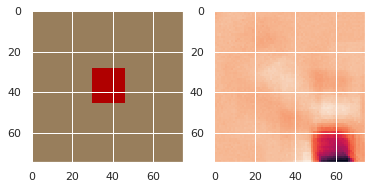

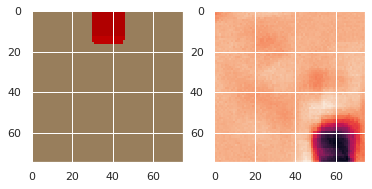

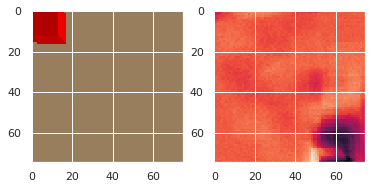

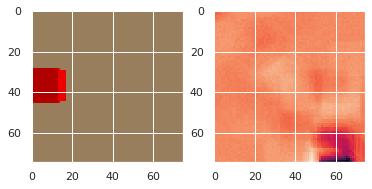

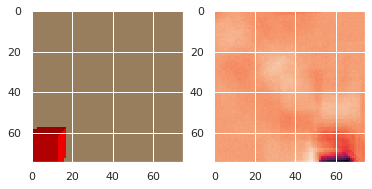

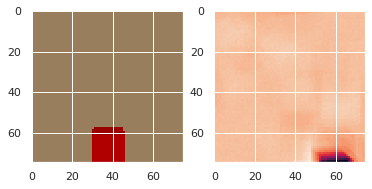

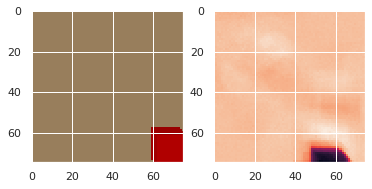

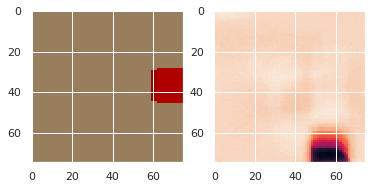

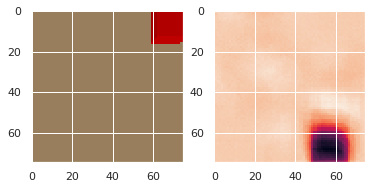

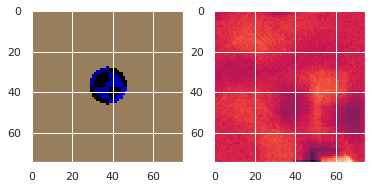

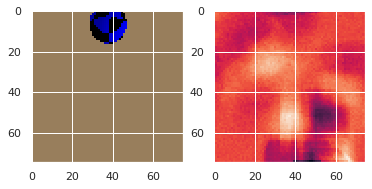

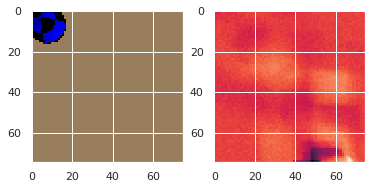

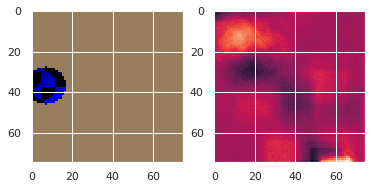

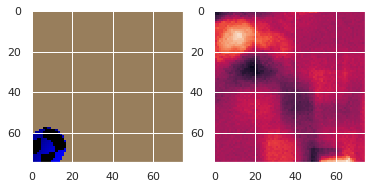

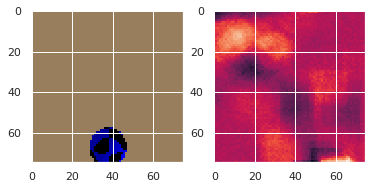

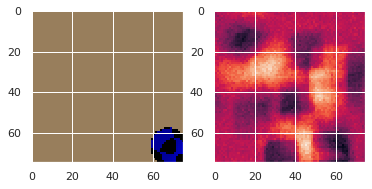

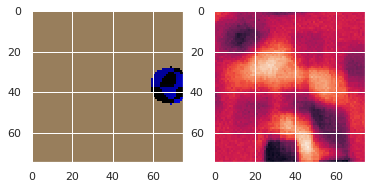

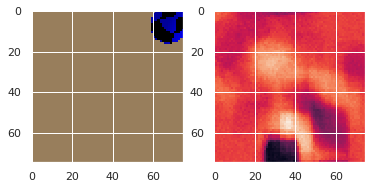

In [14]:
for i in range(len(testbuffer)):
    fig, axes = plt.subplots(1,2)#, figsize=(18, 6))
    axes[0].imshow(testbuffer[i][1].T)
    axes[1].imshow((ycheck1[i]).T)
#     axes[2].imshow((ycheck2[i][0]).T)
    plt.show()
